<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-3/phase3_part2_2nd_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://drive.google.com/file/d/1blGgEOlrHrM0-NAQxYVRwMlfiHDvVHXb/view
#!pip install --upgrade --no-cache-dir gdown
#!gdown --id "1blGgEOlrHrM0-NAQxYVRwMlfiHDvVHXb"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1blGgEOlrHrM0-NAQxYVRwMlfiHDvVHXb
To: /content/InstaNY100K.zip
100% 1.87G/1.87G [00:10<00:00, 175MB/s]


In [ ]:
#!unzip InstaNY100K

In [4]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import json 

api = {"username":"a80abbasi","key":"c64917f1d1c750fbbeed83ac15b782e8"}
with open('kaggle.json', 'w') as f:
    json.dump(api, f)

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [05:59<00:00, 24.3MB/s]
100% 8.16G/8.16G [05:59<00:00, 24.4MB/s]


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!cp flickr-image-dataset.zip drive/MyDrive

In [ ]:
!unzip flickr-image-dataset.zip

# Dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [18]:
from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from torchvision import transforms

In [14]:
df = pd.read_csv('./flickr30k_images/results.csv', delimiter='|')
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [15]:
class MultiModalDataset (Dataset):
  def __init__(self, dataset_dir, images_dir, texts, transform=None, preprocess_func=None, pad_idx=None, max_len=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.text_path = self.dataset_path / texts

    self.transform = transform

    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    self.file_names = [(self.images_path/f).stem for f in os.listdir(self.images_path)]
    # shuffle
    self.file_names = np.random.permutation(self.file_names)
    
  def __len__(self):
        return len(self.file_names)

  def __getitem__(self, idx):
        img_path = self.images_path / f'{self.file_names[idx]}.jpg'
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
       
        text_path = self.text_path / f'{self.file_names[idx]}.txt'
        with open(text_path.absolute(), 'r') as f:
            text = f.read()

        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        
        return image, text

In [16]:
class MultiModalDataset (Dataset):
  def __init__(self, dataset_dir, images_dir, texts, transform, preprocess_func=None, pad_idx=None, max_len=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.text_path = self.dataset_path / texts
    self.transform = transform

    self.preprocess_func = preprocess_func
    self.pad_idx = pad_idx
    self.max_len = max_len

    self.df = pd.read_csv(self.text_path, delimiter='|')
    self.df.columns = [col.strip() for col in self.df.columns]
    # shuffle
    self.df = self.df.sample(frac=1).reset_index()
    
  def __len__(self):
        return len(self.df)

  def __getitem__(self, idx):
        img_path = self.images_path / self.df.loc[idx, 'image_name']
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
       
        text = self.df.loc[idx, 'comment']

        if self.preprocess_func is not None:
            text = self.preprocess_func(text)
            if self.max_len is not None:
                text = text[:self.max_len]
            if self.pad_idx is not None:
                text = F.pad(torch.tensor(text), (0, self.max_len - len(text)), 'constant', self.pad_idx)
        
        return image, text

In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.2 MB/s eta 0:00:00


In [27]:
from transformers import BertConfig, BertTokenizer, BertForSequenceClassification
from torchvision import transforms

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# general config
MAX_LEN = 30

TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
TEST_BATCH_SIZE = 64

EPOCHS = 4
LEARNING_RATE = 5e-5

MODEL_NAME = 'bert-base-uncased'

In [29]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
config = BertConfig.from_pretrained(MODEL_NAME)

In [30]:
def bert_preprocess(text):
    # text = sent_preprocess(text)
    return tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        padding='max_length',
        return_tensors='pt',
    )
transform = transforms.Compose([transforms.ToTensor()
                                ,transforms.Resize((288,288),transforms.InterpolationMode("bicubic"))
                                ,transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])    

In [31]:

dataset = MultiModalDataset('./flickr30k_images', 'flickr30k_images', 'results.csv',transform, preprocess_func=bert_preprocess)

In [ ]:
#dataset = MultiModalDataset('./InstaNY100K', 'img_resized/newyork', 'captions/newyork')

In [32]:
len(dataset)

158915

In [ ]:
img, text = dataset[43]
text

In [34]:
img

tensor([[[-1.3818, -1.9197, -1.9686,  ...,  0.5188, -0.6799, -0.6316],
         [-1.9895, -1.8757, -1.8665,  ..., -1.1366, -2.0356, -1.4746],
         [-1.7962, -2.0888, -1.3564,  ..., -1.6798, -2.0171, -1.7802],
         ...,
         [ 0.2269,  0.3553,  0.4122,  ...,  0.3937,  0.3174,  0.3952],
         [ 0.1254, -0.0502,  0.1406,  ...,  0.5410,  0.4618,  0.4655],
         [ 0.0707,  0.3586, -0.1358,  ...,  0.4350,  0.3138,  0.1520]],

        [[-1.0963, -1.7122, -1.5233,  ..., -0.0772, -0.3560,  0.0655],
         [-1.5795, -1.7441, -1.6194,  ..., -1.1331, -1.6792, -1.3218],
         [-1.5405, -1.2322, -1.4460,  ..., -1.5483, -1.6548, -1.6470],
         ...,
         [-0.1801, -0.2133, -0.1930,  ..., -0.0290,  0.0090, -0.2076],
         [-0.3749, -0.3939, -0.2801,  ..., -0.2162, -0.1988, -0.2779],
         [-0.2827, -0.4019, -0.2831,  ..., -0.1332, -0.3245, -0.4826]],

        [[-0.5485, -1.6273, -1.5566,  ...,  0.4323,  0.5779,  0.9507],
         [-1.3320, -1.5721, -1.3405,  ..., -0

## Processing Text

In [35]:
!pip install pyenchant

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 6.3 MB/s eta 0:00:00


In [36]:
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import enchant
english_dict = enchant.Dict("en_US")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [37]:
!pip install emoji

import emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=cbfa5be6c0e2c7f3f0cbf0e9f537676c66c8e9a1a989cda28a5ada9475c7f2a8
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [38]:
NUM = '<NUM>'
UNK = '<UNK>'

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def sent_preprocess(sent, lower=True, remove_punct=True, remove_stopwords=False,
                    lemmatize=False, handle_nums=False, handle_unknowns=False, remove_emojies=True, join=True):
    if lower:
        sent = sent.lower()
    
    if remove_punct:
        sent = sent.translate(str.maketrans('', '', string.punctuation))

    if remove_emojies:
        sent = emoji.replace_emoji(sent)
    
    word_tokens = word_tokenize(sent)

    if remove_stopwords:
        word_tokens = [w for w in word_tokens if not w in stop_words]

    if lemmatize:
        word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    if handle_nums:
        
        def is_number(s):
            if s.isdigit():
                return True
            if s[:-2].isdigit():
                if s[-2:] == 'th' or s[-2:] == 'st' or s[-2:] == 'nd' or s[-2:] == 'rd':
                    return True
            return False

        word_tokens = [NUM if is_number(w) else w for w in word_tokens]

    if handle_unknowns:
        word_tokens = [w if english_dict.check(w) else UNK for w in word_tokens]

    if join:
        return ' '.join(word_tokens)

    return word_tokens

## Bert Config

In [ ]:
#dataset = MultiModalDataset('./InstaNY100K', 'img_resized/newyork', 'captions/newyork', transform=transform, preprocess_func=bert_preprocess)

In [79]:
train_size = int(0.3 * len(dataset))
val_size = int(0.06 * len(dataset))
test_size = int(0.06 * len(dataset))
train_size, val_size, test_size

(47674, 9534, 9534)

In [41]:
train_set, val_set, test_set, _ = torch.utils.data.random_split(dataset, [train_size, val_size, test_size, len(dataset) - train_size - val_size - test_size])

In [80]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Model

In [43]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [46]:
%cd drive/MyDrive

/content/drive/MyDrive


In [72]:
# !gdown 11caq-CNLP6_V3106zj0zAkFyYPAjyjyw
#!gdown 14Nh5c1pfzAuLF2nC3-IpugRi7eAMZvhW


from transformers import BertForSequenceClassification

def load_pretrained_bert(name='drive/MyDrive/models/bert_model.pt'):
    model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
    )
    model.load_state_dict(torch.load(name))
    return model

In [48]:
class lastLayer(nn.Module):
    def __init__(self, pretrained):
        super(lastLayer, self).__init__()
        self.pretrained = pretrained
        self.last = nn.Sequential(
            nn.Dropout(p = 0.2,inplace=True),
            nn.Linear(1408, 90),
            nn.Dropout(p = 0.3,inplace=True),
            nn.Linear(90, 30),
            nn.Dropout(p = 0.1,inplace=True),
            nn.Linear(30, 3),
            )
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.last(x)
        return x

In [73]:
#!gdown 1EfyDFNxAHGjvnLPRbP0SfnkV9g33-CFJ

from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

def load_pretrained_image(name ='drive/MyDrive/models/scene_modal_en.pth'):
    image_model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    image_model.classifier = nn.Sequential()
    image_model = lastLayer(image_model)
    image_model.load_state_dict(torch.load(name))
    return image_model

# Training

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [51]:
import tqdm

def one_epoch(models, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None):
    tmp_accs = []
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    text_model, image_model = models
    text_model.eval()
    if train:
        image_model.train()
    else:
        image_model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader)) as pbar:
        for i, data_i in pbar:
            if train:
                optimizer.zero_grad()
            image, text = data_i
            image = image.to(device)
            input_ids = text['input_ids'].to(device)
            attention_mask = text['attention_mask'].to(device)
            token_type_ids = text['token_type_ids'].to(device)
            input_ids = input_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)

            output = text_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            p_text = output.logits
            p_image = image_model(image)

            y_pred = p_image.argmax(dim=-1)
            y_true = p_text.argmax(dim=-1)

            loss = criterion(p_text, p_image, y_true)
            tmp_accs.append(np.count_nonzero(y_pred.cpu()==y_true.cpu()) / len(y_true.cpu()))
            total_loss += loss.item() * len(image)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / (i+1):.3e} - Accuracy: {sum(tmp_accs)*100/len(tmp_accs):.2f}%')
            if train:
                loss.backward()
                optimizer.step()

            Y.append(y_true.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [52]:
def train_model(models, dataloaders, num_epochs, criterion, optimizer, model_name='pytroch-model', scheduler=None):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf

    text_model, image_model = models

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        result = one_epoch(models, train_loader, criterion, optimizer, epoch, train=True, set_name='Train')
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(models, val_loader, criterion, epoch=epoch, train=False, set_name='Validation')
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print('\n', '-' * 60)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(image_model.state_dict(), f'{model_name}.pt')

        if scheduler:
            scheduler.step(val_loss)

    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('loss history of training and val sets')
    plt.legend()
    plt.show()

    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title('Accuracy history of training and val sets')
    plt.legend()
    plt.show()

    image_model.load_state_dict(torch.load(f'{model_name}.pt'))
    return image_model, min_val_loss

In [76]:
text_model = load_pretrained_bert()
text_model.requires_grad_(False)
text_model.eval()
text_model = text_model.to(device)

image_model = load_pretrained_image()
image_model = image_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [54]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.9, T=2):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.kl_div = nn.KLDivLoss(log_target=True, reduction="batchmean")
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, p_true, p_pred, y_true):
        logit_loss = self.kl_div(F.log_softmax(p_pred / self.T, dim=-1), F.log_softmax(p_true / self.T, dim=-1)) 
        label_loss = self.cross_entropy(p_pred, y_true)
        return (1-self.alpha) * label_loss + self.alpha * self.T * self.T * logit_loss

In [77]:
# Training Configuration
LEARNING_RATE = 1e-5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, image_model.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, verbose=True, factor=0.5)
criterion = DistillationLoss(alpha=0.9)

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
pt_model = None

!nvidia-smi

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

In [82]:
def eval_model(models, loader, metrics=metrics, set_name='Test', plot_confusion_matrix=True):
    results = one_epoch(models, loader, criterion, train=False, set_name=set_name, metrics=metrics)
    disp = ConfusionMatrixDisplay(results.pop('confusion_matrix'))
    if plot_confusion_matrix:
        disp.plot()
    return results

### Before training:

In [60]:
#%cd ../..

/content


: Test Loss: 2.472e+01 - Accuracy: 44.73%: 100%|██████████| 50/50 [00:48<00:00,  1.02it/s]

Accuracy of Test set: 0.44808055380742606



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.3888651454988855,
 'accuracy': 0.44808055380742606,
 'precision': 0.3333333333333333,
 'recall': 0.14936018460247535,
 'f1': 0.20628712154135884}

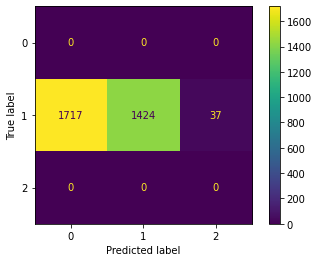

In [83]:
eval_model((text_model, image_model), test_loader)

In [62]:
# image_model = load_pretrained_image()
# image_model.to(device);

EPOCH = 2
image_model, min_val_loss = train_model((text_model, image_model), (train_loader, val_loader), EPOCH, criterion, optimizer, model_name='weakly_sup', scheduler=scheduler)

0: Train Loss: 2.472e+01 - Accuracy: 83.52%:   2%|▏         | 11/497 [00:12<08:50,  1.09s/it]


TypeError: ignored

: Test Loss: 2.542e+01 - Accuracy: 79.95%: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]

Accuracy of Test set: 0.8001887979861548



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.7998910656959625,
 'accuracy': 0.8001887979861548,
 'precision': 0.3333333333333333,
 'recall': 0.26672959932871826,
 'f1': 0.2963351395443687}

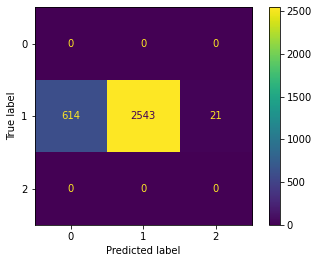

In [63]:
eval_model((text_model, image_model), test_loader)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd content/drive/MyDrive
torch.save(text_model.state_dict(), 'models/bert_model_weak_sup.pt')
torch.save(image_model.state_dict(), 'models/scene_model_weak_sup.pt')